In [1]:
# Imports

import pandas as pd
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
# INPUT PARAMETERS

split_size = 0.80
EVALUATION_INTERVAL = 200


EPOCHS = 40
time_step =  120
L1 = 60
L2 = 60
#L3 = 30
#L4 = 30

LD1 = 1

Patience = 3
BATCH_SIZE = 256
BUFFER_SIZE = 10000

#scaler = StandardScaler()                                    # Scale of the output and input to match the scale of the layer of LSTM
scaler = MinMaxScaler(feature_range = (0,1))                # scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM



In [3]:
# Function to Extract data from csv to Dataframe

def excel_to_df(url):

    match = re.search(r'(\d+)_merged\.csv', url)                    # Extracting meter number from CSV name
    meter_number = match.group(1)
    dataframe = pd.read_csv(url)
    
    df_daily = dataframe.copy()                                                 # Copying main dataframe to create daily consumption data frame
    df_daily['Meter_reading'] =  df_daily.iloc[:, 2:26].sum(axis=1)       # Adding up 24 hours datapoint values
    df_daily = df_daily.drop(df_daily.iloc[:, 1:26],axis=1)                     # Dropping hourly columns after adding

    if (df_daily['Meter_reading'] == 0).any():  # Checks if any value in 'Meter_reading' column is zero
        return None, meter_number  # If zero value exists, return None for dataframe

    return df_daily, meter_number



# Normalising and dividing data into Train, Val and test

def data_splitting_shapping(dataset):
    
    if isinstance(dataset, pd.Series):
        target_dataset = dataset #For Transfer learning
    else:
        target_dataset = dataset["Meter_reading"] #For meter prediction

    # Standardize the data before model fitting as it will boost the performance( in neural networks)
    target_dataset = scaler.fit_transform(np.array(target_dataset).reshape(-1,1))       # reshape: convert the univariate 1D array into 2D
    
    train_size = int(len(target_dataset)*split_size)
    test_size = len(target_dataset)- train_size
    val_size = int(train_size*0.20)
    
    train_data = target_dataset[0:train_size-val_size, : ]                # Splitting data into train test Val
    test_data = target_dataset[train_size:len(target_dataset), :1 ]
    val_data = target_dataset[len(target_dataset)-test_size-val_size:len(target_dataset)-test_size, :1 ]

    def create_dataset(dataset, time_step = 1):                 # Function to create X and Y nparray from dataset and timestep for LSTM model
        dataX, dataY = [] , []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step),0]
            dataX.append(a)
            dataY.append(dataset[i + time_step,0])
        return np.array(dataX), np.array(dataY)
    
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    X_val, y_val = create_dataset(val_data, time_step)

    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)         # Reshaping arrays according LSTM model
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

    train_univariate = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_univariate = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
    
    return X_train, X_test, X_val, y_train, y_test, y_val, train_univariate, val_univariate, test_data



# Model evaluation to find MAE, MAPE, RMSE

def model_eval( simple_lstm_model, scaler, X_test, y_test):

   # Predicting consumption using test data
   
   test_predictions_1 = simple_lstm_model.predict(X_test)

   test_predictions =scaler.inverse_transform(test_predictions_1)

   y_test = y_test.reshape(y_test.shape[0], 1)

   actual_test = scaler.inverse_transform(y_test)

   mean_actual = np.mean(actual_test)  # Calculate the mean of the actual target variable

   # A lower RMSE, MAE, and MAPE for your model compared to the baseline indicate that your model is performing better.
   
   raw_errors = test_predictions - actual_test

   # Calculate MAE (Mean Absolute error)
   mae_test = np.mean(np.abs(test_predictions - actual_test))


   # Calculate MAPE (Mean Absolute Percentage Error)
   #epsilon = 1e-10  # Small constant to avoid division by zero
   denominator = np.where(actual_test != 0, actual_test, 1)
   mape_test = np.mean(np.abs((actual_test - test_predictions) / denominator)) * 100


   # Calculate RMSE (Root Mean Squared Error)
   rmse_test = np.sqrt(np.mean((test_predictions - actual_test) ** 2))

   return mae_test, mape_test, rmse_test, test_predictions, actual_test, mean_actual, raw_errors



# Plotting Energy distribution and Model loss

def loss_graph(history):
    plt.figure(figsize=(10, 5))

    # Plot model loss on the left side
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
                                    
    plt.show()

    

# Plotting graph call

def plot_graphs(Meter_number, mae_test, mape_test, rmse_test, dataset, test_predictions, actual_test, raw_errors):
    
    # Print the results
    print("=================================")
    print("Results of meter:- ",Meter_number)
    print("MAE:", mae_test)
    print("MAPE:", mape_test)
    print("RMSE:", rmse_test)
    print("=================================")

    # Plot the actual values and test predictions

    indices = range(len(actual_test))                       # Create a range of indices for the data points
    plt.figure(figsize=(16, 5))
    plt.plot(indices, actual_test, label='Actuals', linestyle='-',linewidth=1, color = 'blue' )
    plt.plot(indices, test_predictions, label='Test Predictions', linestyle='--',linewidth=1, color = 'red')
    plt.xlabel('Day')
    plt.ylabel('Consumption in KW')
    plt.title('Actuals vs. Test Predictions (Meter: {})'.format(Meter_number))
    plt.legend()
    plt.grid(True)
    plt.show()

    #Plot_Energy_Distribution

    #sns.distplot(dataset["Meter_reading"])
    #plt.title('Energy Distribution')



# Results to Excel

def results_OP(Results, output_folder):
    # create a DataFrame from the results
    Results_df = pd.DataFrame(Results, columns=['Meter_number', 'MAE', 'MAPE', 'RMSE', 'Time step','L1'])

    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_excel = os.path.join(output_folder, 'Results_L1_{}_timestep_{}_{}.xlsx'.format(L1, time_step, current_time))

    Results_df.to_excel(output_excel, index=False)                  # Save the DataFrame to a CSV file

    if os.path.exists(output_excel):
        print(f"CSV file saved to {output_excel}")
    else:
        print("Error: CSV file not saved.")

In [4]:
# Future value prediction function

def future_predict(test_data, n_steps, days_to_predict, Meter_number, simple_lstm_model):

    #print(len(test_data))          # 366 values
    x_input = test_data[len(test_data)- n_steps:].reshape(1,-1)
    #print(x_input.shape)           # (1, 60)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    i = 0
    test = ""

    while(i < days_to_predict):    #prediction for next 30 days
        
        if(len(temp_input)>60):

            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)

            yhat = simple_lstm_model.predict(x_input, verbose=0)
            #print("{} day output {}".format(i,yhat))

            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1

        else:

            x_input = x_input.reshape((1, n_steps,1))

            yhat = simple_lstm_model.predict(x_input, verbose=0)

            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1

    day_new = np.arange(1, len(test_data))
    day_pred = np.arange(len(test_data), len(test_data)+days_to_predict)

    combined_dataplot = np.concatenate((scaler.inverse_transform(test_data[1:]), scaler.inverse_transform(lst_output)))       # Concatenate the actual data and predicted data
    combined_daysplot = np.concatenate((day_new, day_pred))

    plt.figure(figsize=(16, 5))

    plt.plot(combined_daysplot, combined_dataplot, color='blue', label='Actual Data',linewidth=1)  # Actual data in blue, predicted data in red
    plt.plot(day_pred, scaler.inverse_transform(lst_output), color='red', label=f'Predicted Data for next {days_to_predict} days',linewidth=1)      # Highlight the predicted data

    plt.xlabel('Day')
    plt.ylabel('Consumption in KW')
    plt.legend()
    plt.title('Actual and Predicted consumption (Meter: {})'.format(Meter_number))
    plt.grid(True)
    plt.show()

    return lst_output


In [9]:
# TRANSFER LEARNING LSTM Architecture

def lstm_archi(X_train, y_train, X_val, y_val, train_univariate, val_univariate):
    
    early_stopping = EarlyStopping(monitor = 'loss', patience=3)                 # Define the early stopping callback

    tf.keras.backend.clear_session()
    
    simple_lstm_model = Sequential()
            
    #simple_lstm_model.add(LSTM(units=L1, input_shape = (time_step, 1)))      # Model Architecture

    #simple_lstm_model.add(LSTM(units=L2))

    

    simple_lstm_model.add(LSTM(units=L1, return_sequences= True, input_shape=(time_step, 1)))      # Model Architecture
    #simple_lstm_model.add(Dropout(0.2))

    simple_lstm_model.add(LSTM(units=L2, return_sequences= False))
    #simple_lstm_model.add(Dropout(0.2))

    #simple_lstm_model.add(LSTM(units=L3, return_sequences= False))
    #simple_lstm_model.add(Dropout(0.2))

    #simple_lstm_model.add(LSTM(units=L4))

    
    simple_lstm_model.add(Dense(units = LD1))

    simple_lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    #history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
    #                                validation_data=val_univariate, validation_steps=50, 
    #                                callbacks=[early_stopping], verbose=0)
    
    #history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
                                    #validation_data = val_univariate, validation_steps=50, 
                                    #verbose=0)
    
    history = simple_lstm_model.fit(X_train, y_train, validation_data = (X_val,y_val), verbose = 1,epochs = EPOCHS ,batch_size = 30)


    return simple_lstm_model, history

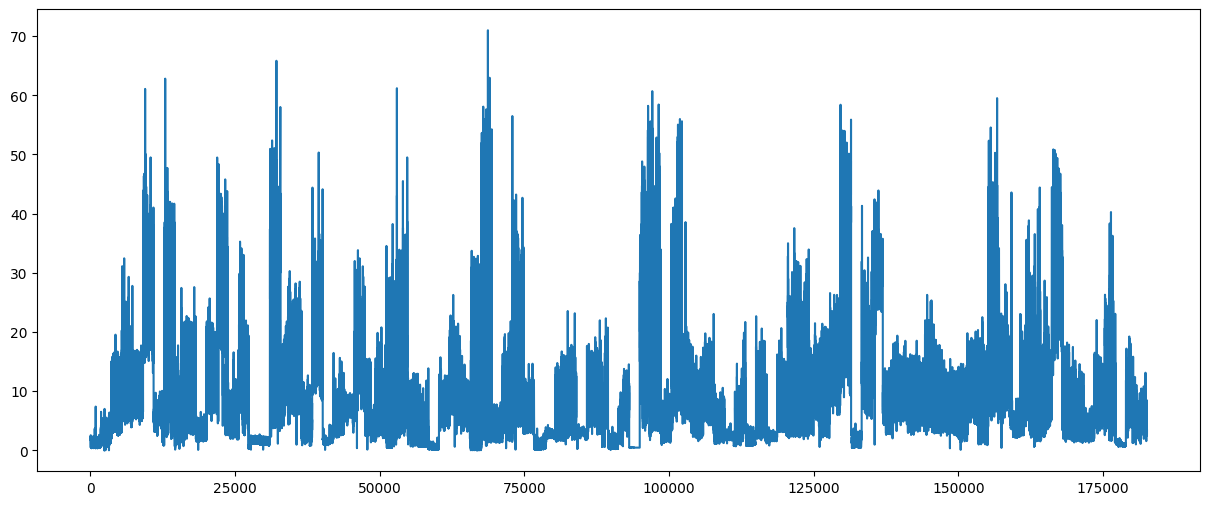

In [6]:
# Creating the combined_dataset from multiple daily df's

folder_path = r'E:\SMART GRID FOR EV\SAME_METERS\TEST_N2_100'   # Specify the folder where your CSV files are located

data_frames = []

for filename in os.listdir(folder_path):                        #Loop through the files in the folder
    if filename.endswith(".csv"):                           
        file_path = os.path.join(folder_path, filename)

        df_daily, Meter_number = excel_to_df(file_path)

        if df_daily is None:                                    # Skipping the meter with zero daily energy consumption
            continue                                            # Skip to the next CSV file

        newdataset = df_daily['Meter_reading']                  # Creating a combined dataset for pre training
        data_frames.append(newdataset)
        combined_dataset = pd.concat(data_frames, axis=0)       # 0 for y axis/ 1 for x axis

combined_df = combined_dataset.to_frame()
       
plt.figure(figsize=(15, 6))
plt.plot(combined_dataset.values)
plt.show()

Epoch 1/40
3892/3892 [==============================] - 327s 83ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/40
3892/3892 [==============================] - 316s 81ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/40
3892/3892 [==============================] - 310s 80ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/40
3892/3892 [==============================] - 322s 83ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/40
3892/3892 [==============================] - 314s 81ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 6/40
3892/3892 [==============================] - 310s 80ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0013 - val_mean_squared_error: 0.001

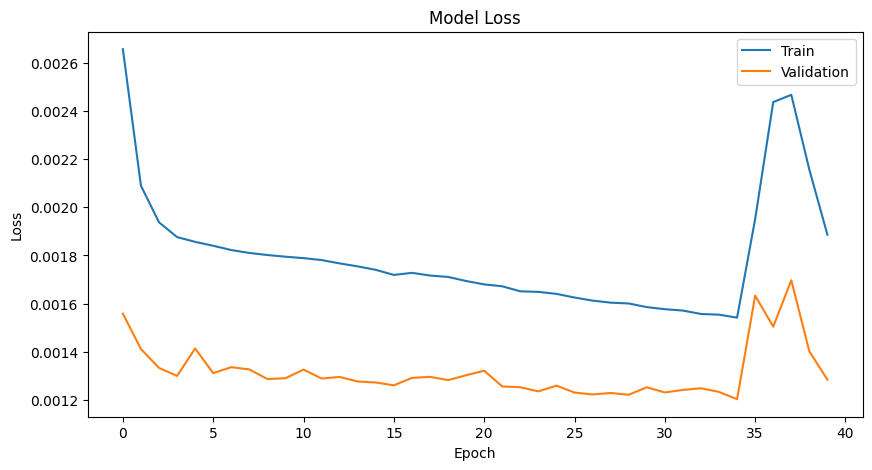

In [12]:
# Split, train combined dataframe

X_train, X_test, X_val, y_train, y_test, y_val, train_univariate, val_univariate, combined_test_data = data_splitting_shapping(combined_df)

simple_lstm_model, history = lstm_archi(X_train, y_train, X_val, y_val, train_univariate, val_univariate)

simple_lstm_model.summary()

loss_graph(history)

8/8 [==============================] - 1s 26ms/step
Results of meter:-  52529
MAE: 0.5265319133524992
MAPE: 17.046402102214785
RMSE: 0.684504466247469


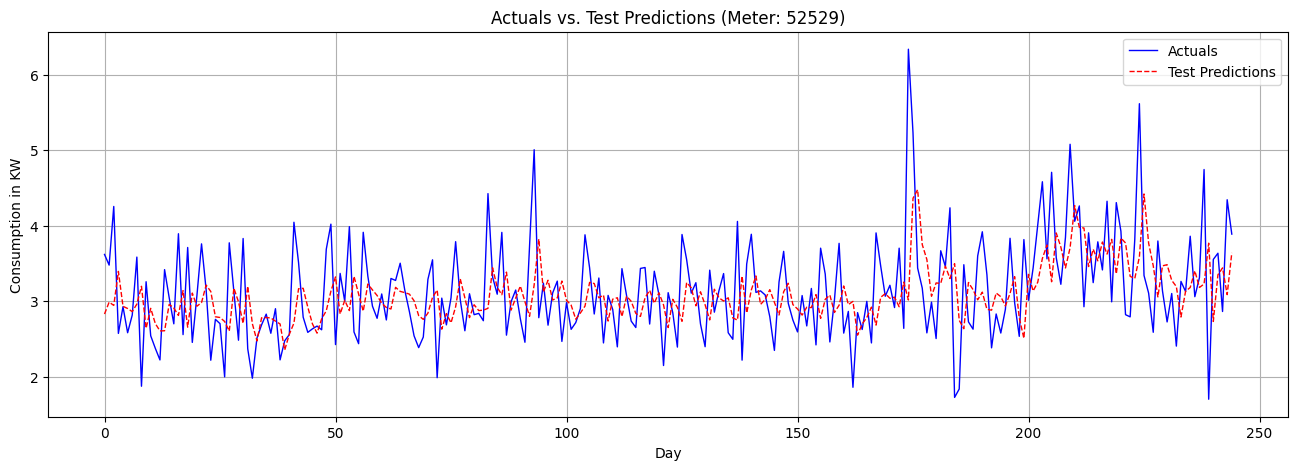

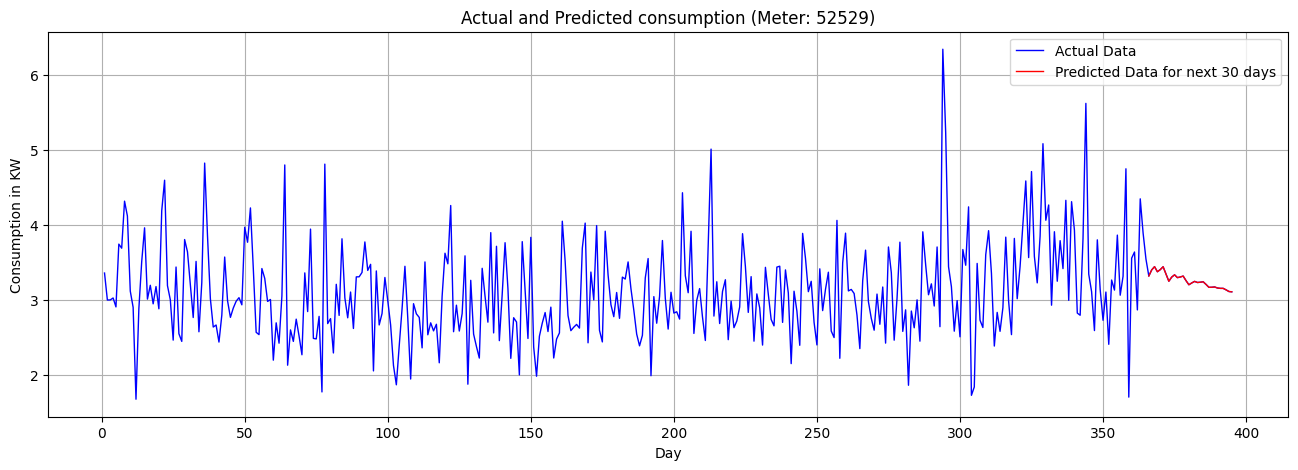

8/8 [==============================] - 0s 26ms/step
Results of meter:-  62697
MAE: 0.09859257279999364
MAPE: 1.1752835399162398
RMSE: 0.11242388074883053


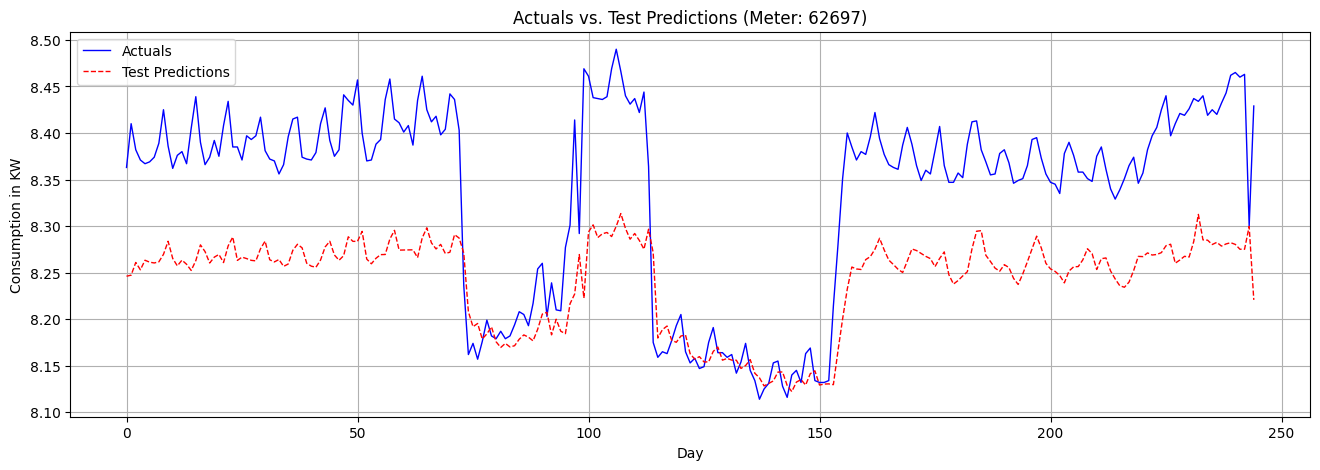

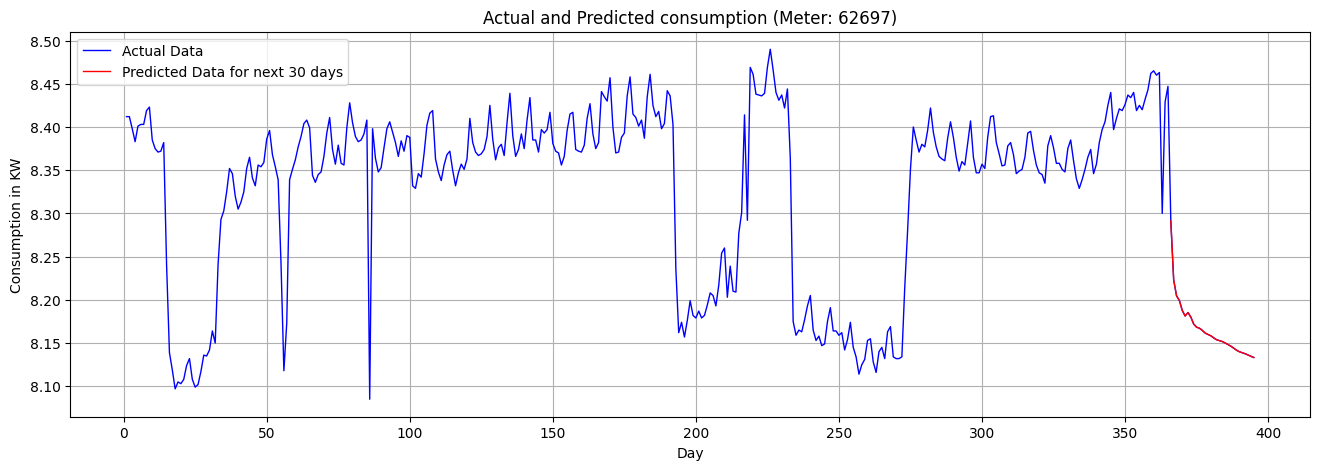

8/8 [==============================] - 0s 26ms/step
Results of meter:-  65481
MAE: 0.0962700078224649
MAPE: 2.03787725863906
RMSE: 0.18060237830539388


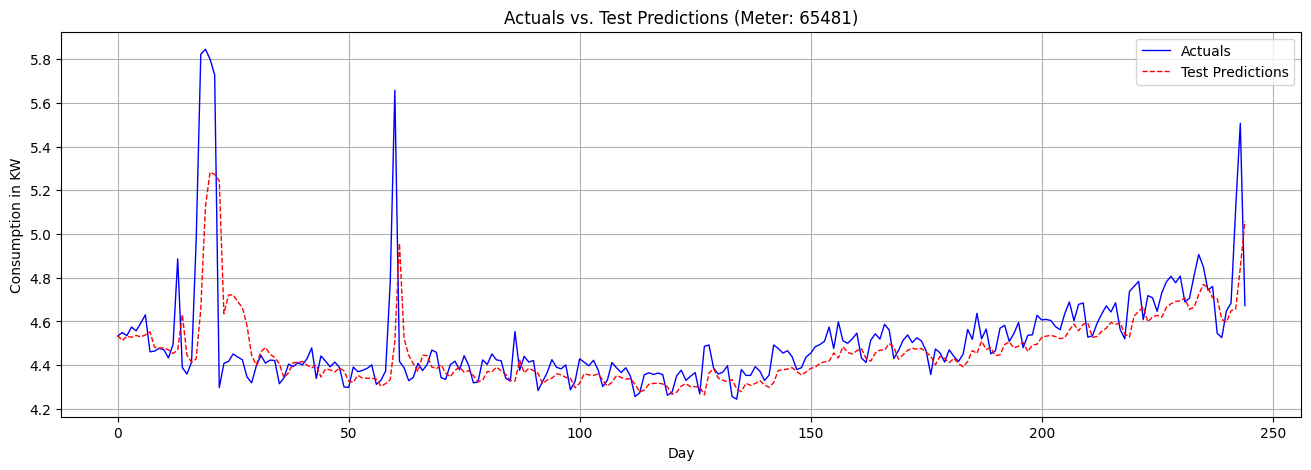

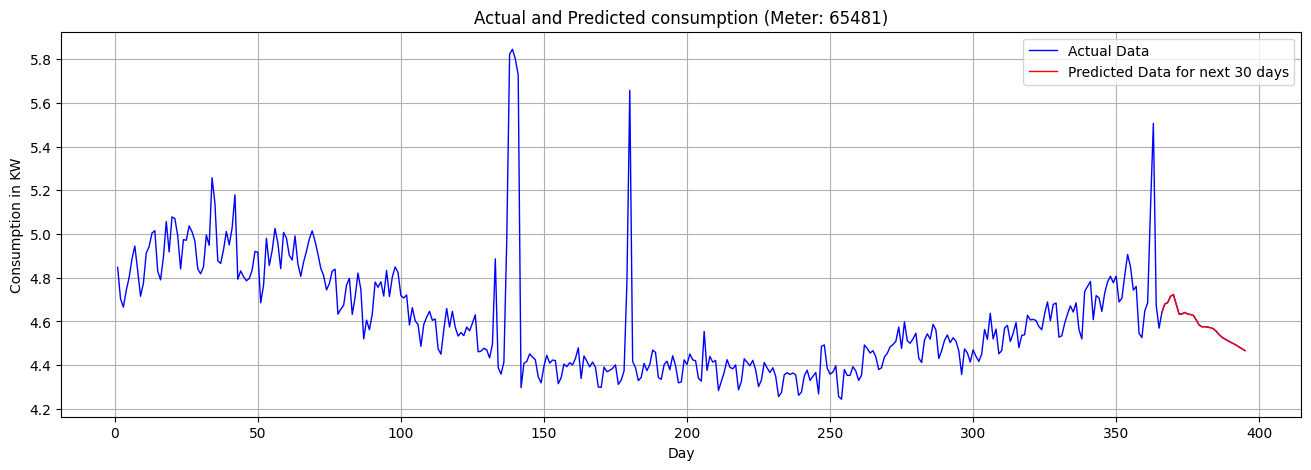

8/8 [==============================] - 0s 24ms/step
Results of meter:-  74265
MAE: 0.42731078827527097
MAPE: 3.4741084855291113
RMSE: 0.6365837134023187


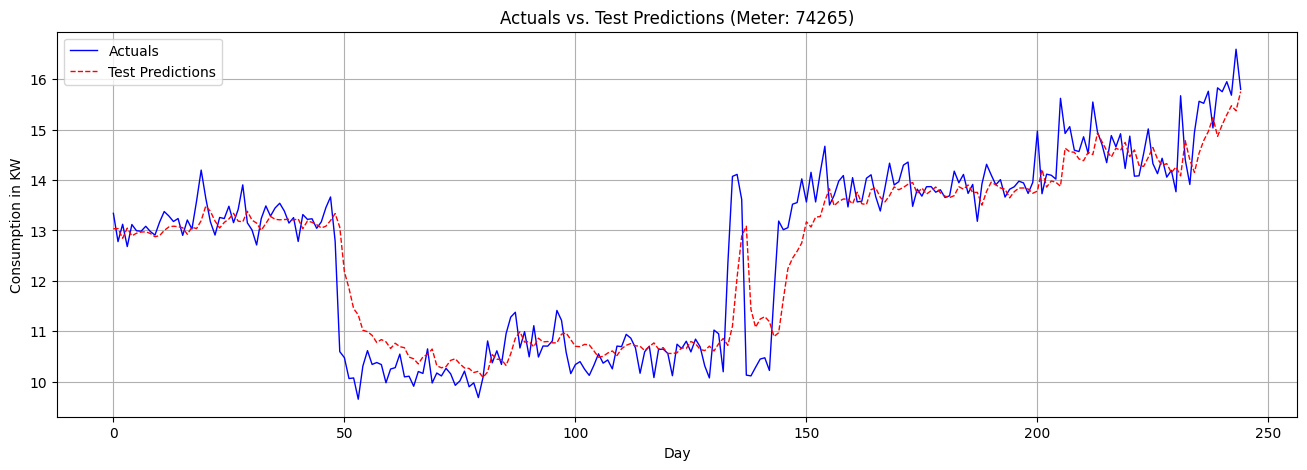

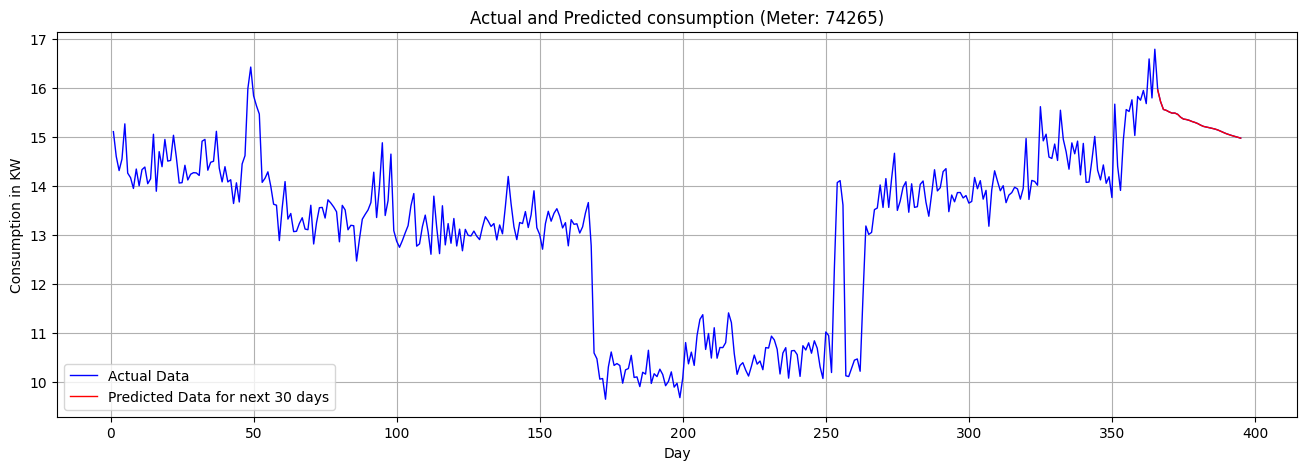

8/8 [==============================] - 0s 26ms/step
Results of meter:-  75761
MAE: 0.8569443887515945
MAPE: 4.077014725308528
RMSE: 1.0493910677164442


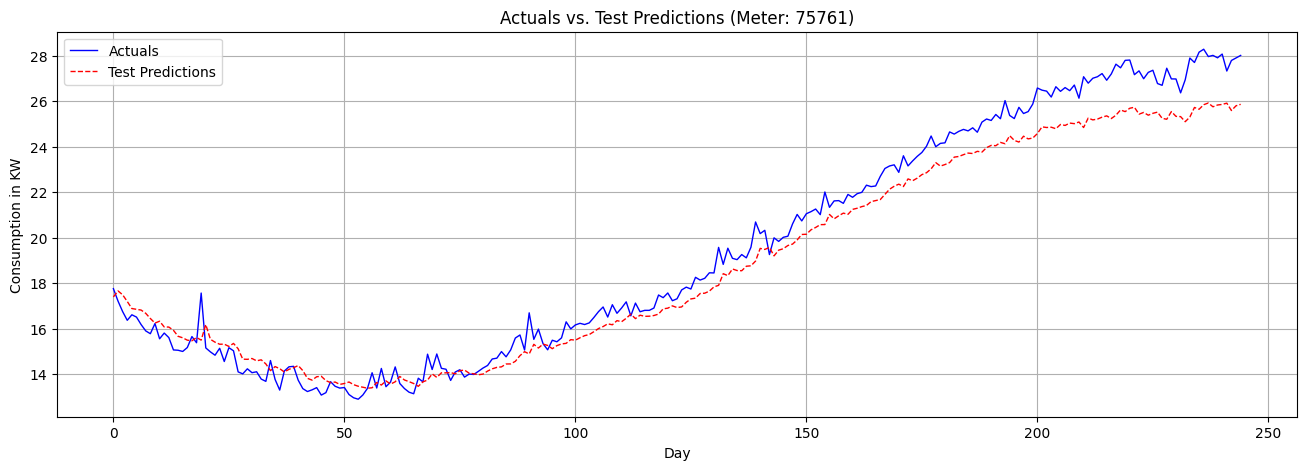

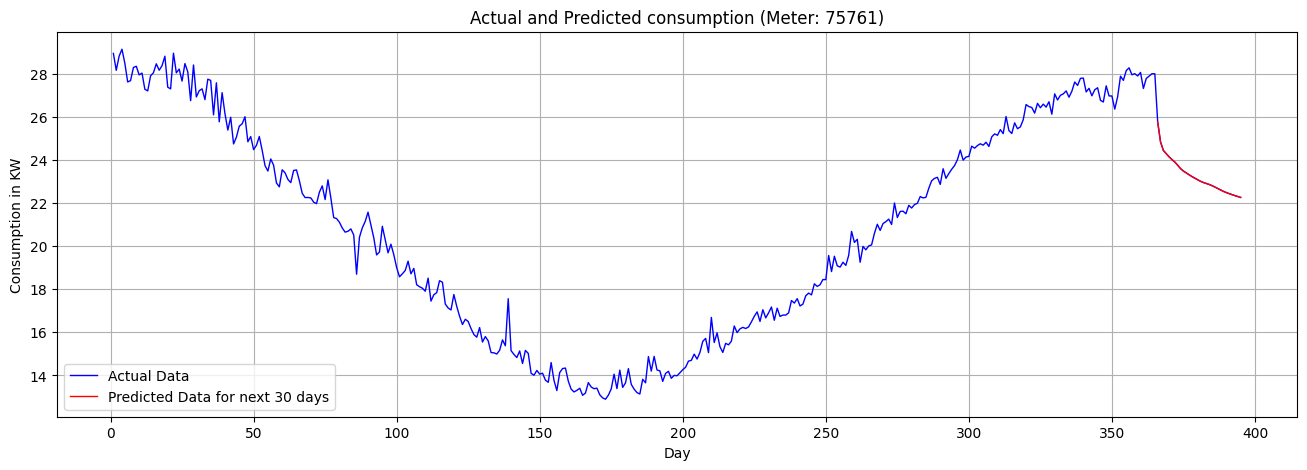

8/8 [==============================] - 0s 28ms/step
Results of meter:-  87177
MAE: 0.40392784769486395
MAPE: 3.7651061564271067
RMSE: 0.4643256129784023


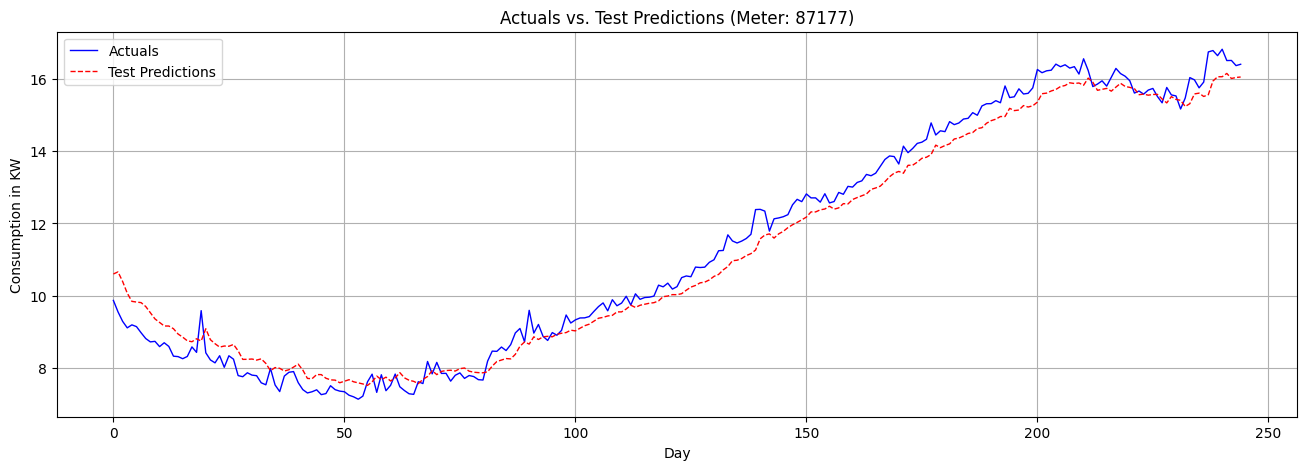

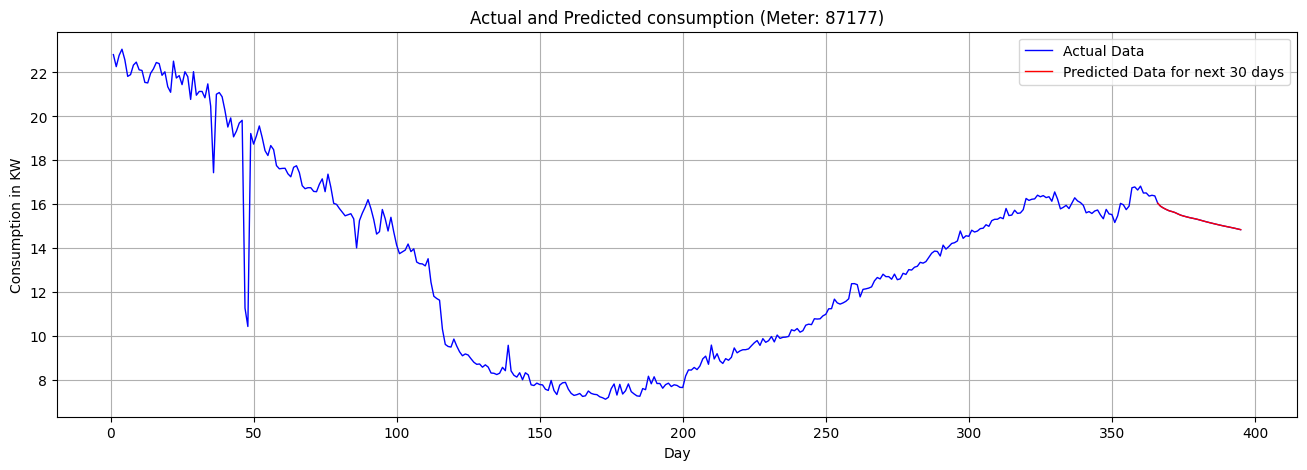

8/8 [==============================] - 0s 23ms/step
Results of meter:-  87801
MAE: 0.677920837651467
MAPE: 3.926912774267583
RMSE: 0.8257760503542104


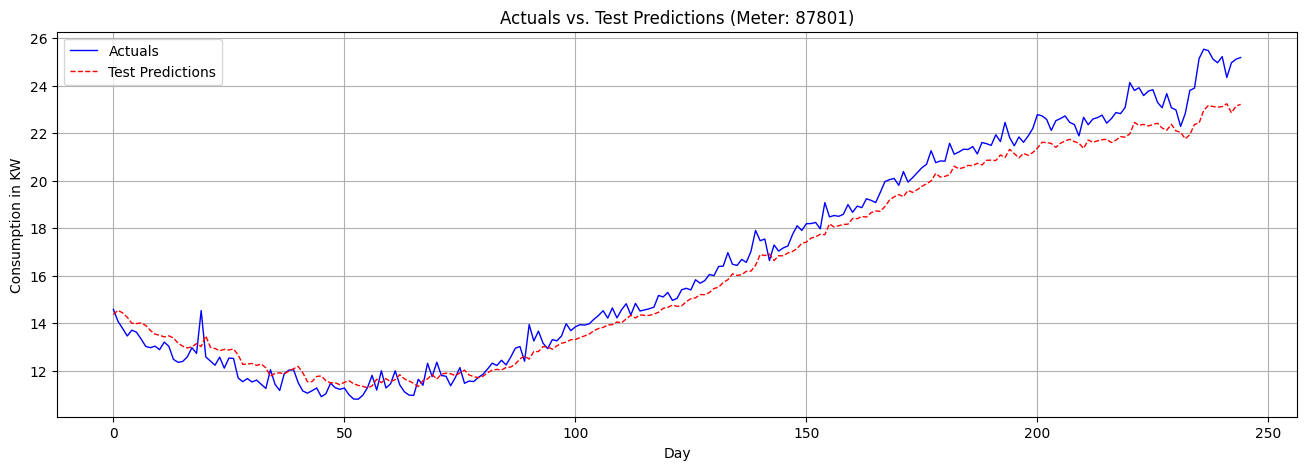

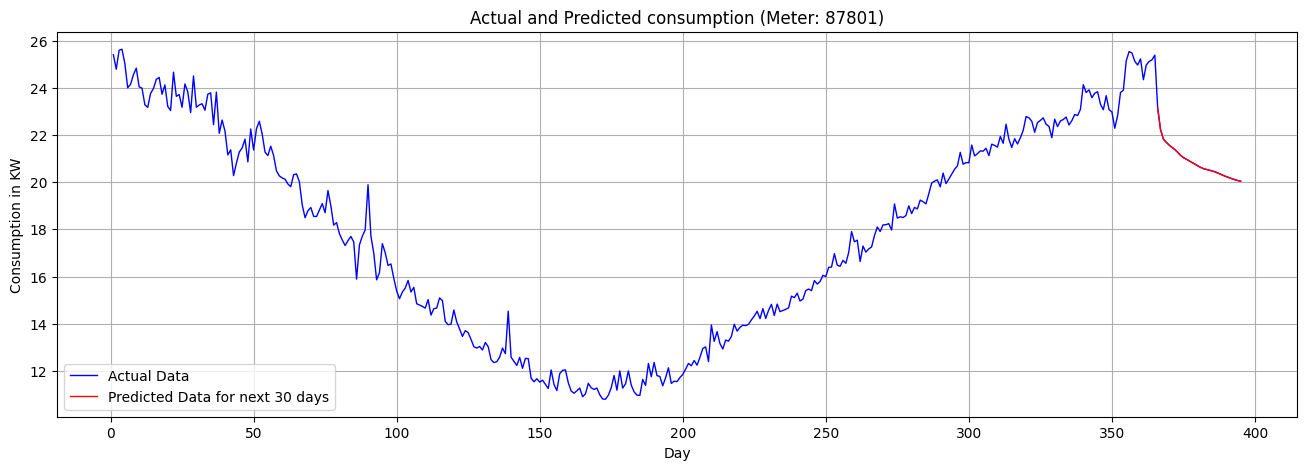

8/8 [==============================] - 0s 25ms/step
Results of meter:-  90153
MAE: 0.0005545564911803462
MAPE: 0.7495033612869136
RMSE: 0.0006990958304717215


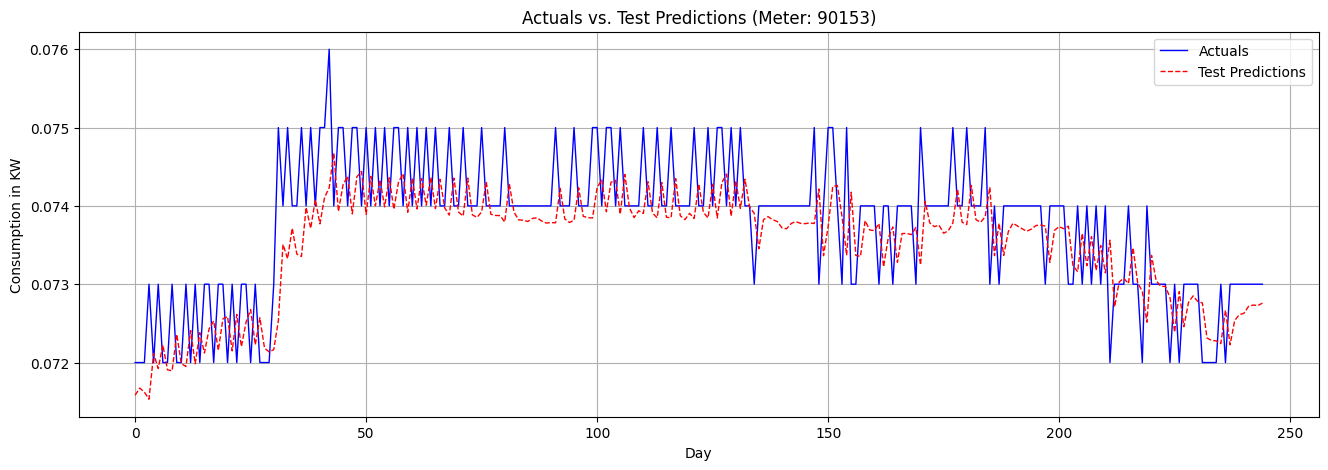

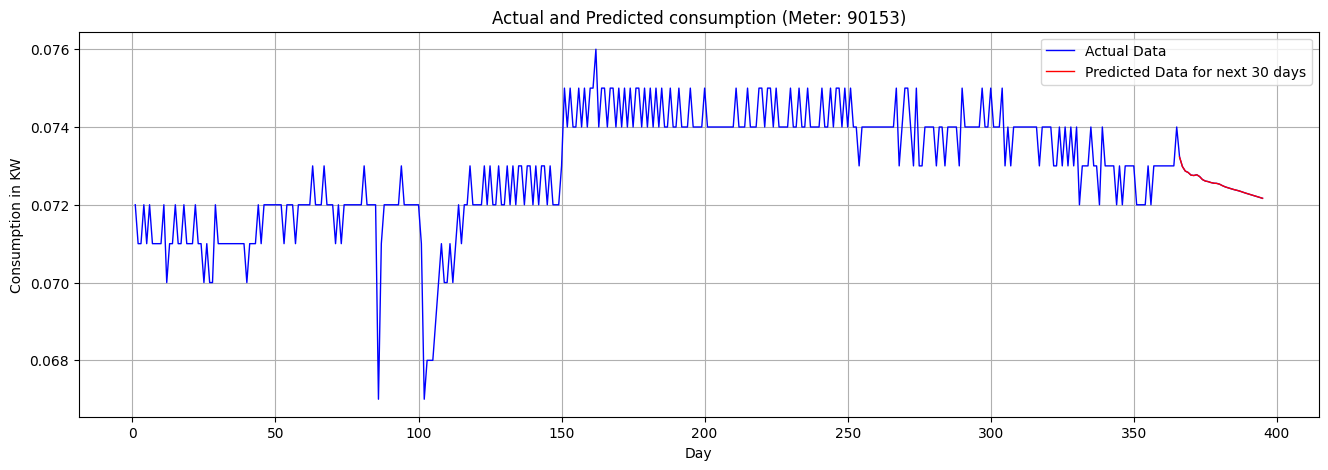

8/8 [==============================] - 0s 25ms/step
Results of meter:-  96049
MAE: 0.06182815456779654
MAPE: 0.9781487862441759
RMSE: 0.07282190322110078


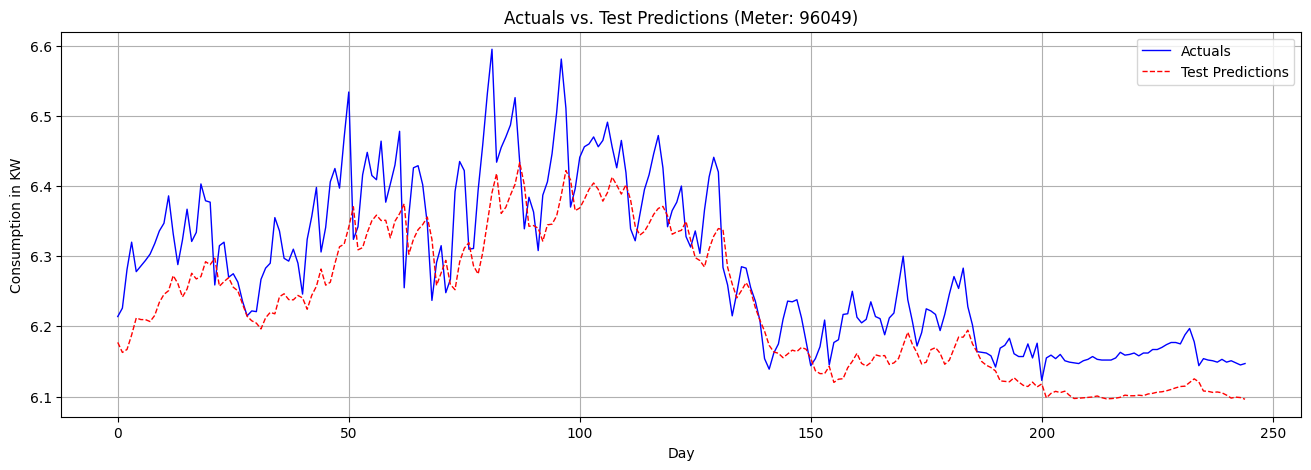

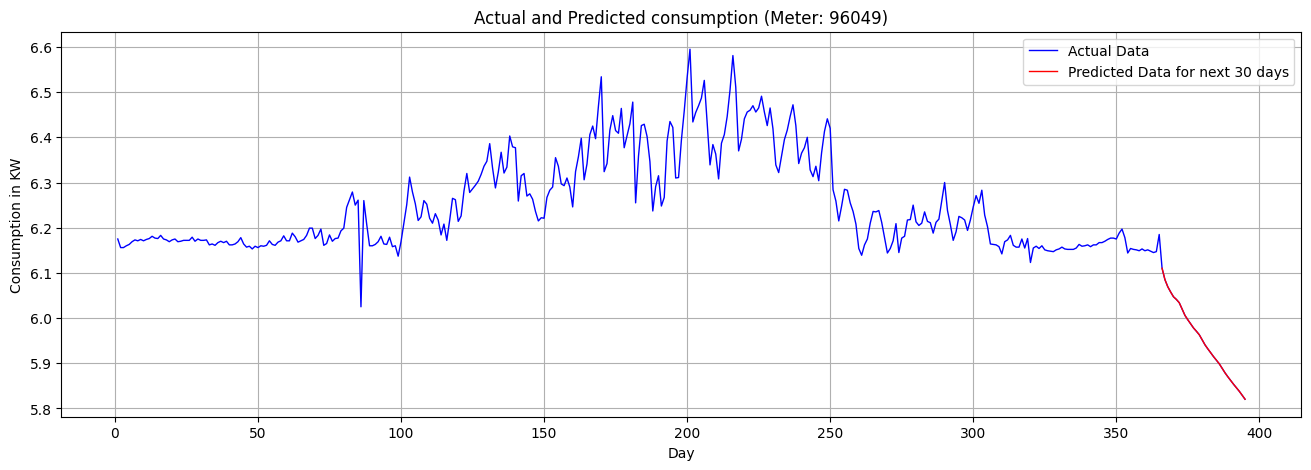

8/8 [==============================] - 0s 32ms/step
Results of meter:-  97497
MAE: 0.10481539020927592
MAPE: 2.358428228125898
RMSE: 0.1698650629281876


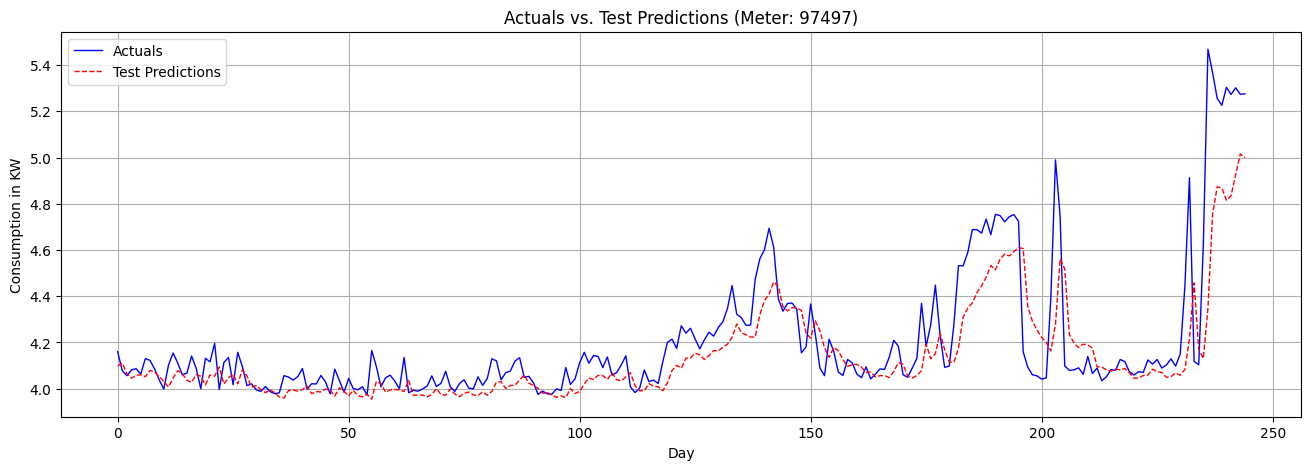

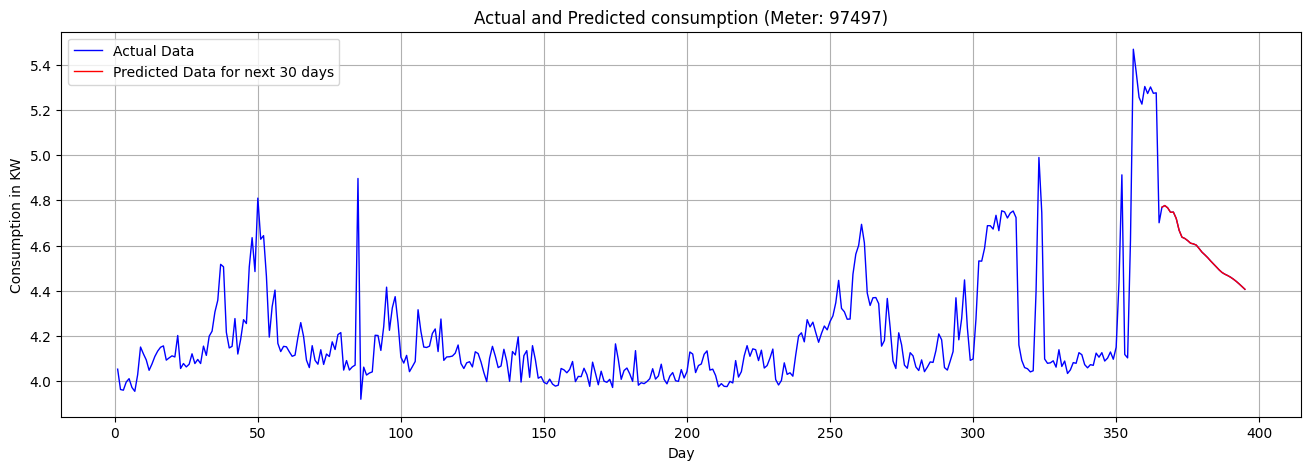

8/8 [==============================] - 0s 25ms/step
Results of meter:-  98633
MAE: 0.000667837131084228
MAPE: 2.261794607840463
RMSE: 0.0008552027730582204


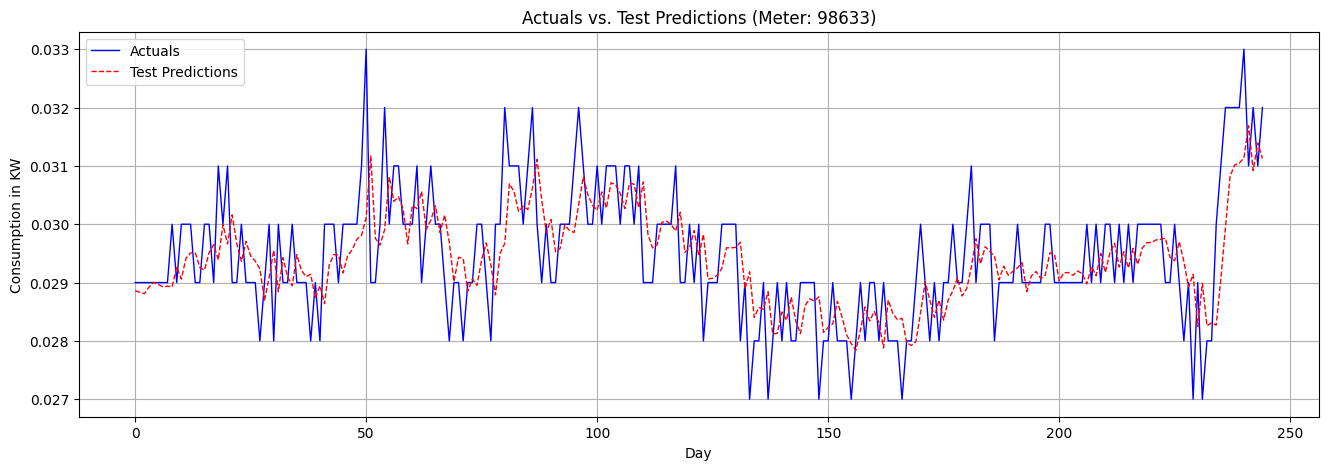

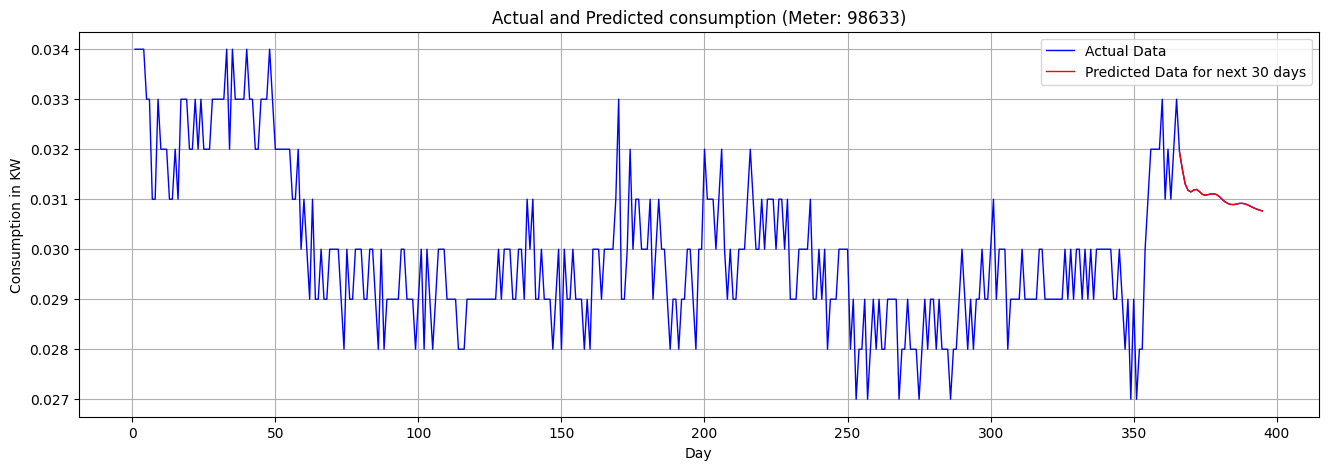

CSV file saved to E:\SMART GRID FOR EV\RESULTS\NEW_RESULTS\Results_L1_60_timestep_120_20240515_175208.xlsx


In [13]:
# Individual meter data reading, predicting and exporting the results


M_folder_path = r'E:\SMART GRID FOR EV\SAME_METERS\TESTING_10'  # Specify the folder where your CSV files for meters consumption to predict are located

output_folder = r"E:\SMART GRID FOR EV\RESULTS\NEW_RESULTS"   # Output foler path to save results

Results = []

for filename in os.listdir(M_folder_path):                   # Loop through the files in the folder
    if filename.endswith(".csv"):                           
        file_path = os.path.join(M_folder_path, filename)

        M_df_daily, M_Meter_number = excel_to_df(file_path)

        if M_df_daily is None:  
            continue                                         # Skip to the next CSV file

        M_dataset = M_df_daily

        M_X_train, M_X_test, M_X_val, M_y_train, M_y_test, M_y_val, M_train_univariate, M_val_univariate, test_data = data_splitting_shapping(M_dataset)

        M_mae_test, M_mape_test, M_rmse_test, M_test_predictions, M_actual_test, M_mean_actual, M_raw_errors = model_eval(simple_lstm_model, scaler, M_X_test, M_y_test)
    
        plot_graphs(M_Meter_number,M_mae_test, M_mape_test, M_rmse_test, M_dataset, M_test_predictions, M_actual_test, M_raw_errors)

        n_steps = 60                                     # Steps to consider to calculate the future          
        days_to_predict = 30                             # demonstrate prediction for next 30 days

        lst_output = future_predict( test_data, n_steps, days_to_predict, M_Meter_number, simple_lstm_model)

        Results.append([M_Meter_number, M_mae_test, M_mape_test, M_rmse_test, time_step, L1])

results_OP(Results, output_folder)